# Course Project: Stacking Regression Models

I built and stacked four linear models to predict the price for AirBnB listings in New York City.

stacking ensemble method to train four regressors.

XXX, this notebook creates four independent regressors using four different types of models:
 * Linear Regression
 * Decision Tree
 * Random Forest
 * Gradient Boosted Decision Tree

Each individual model's performance is analyzed using Root Mean Squared Error, R-Squared, and training time.



Compare the performance of the stacked ensemble model to that of the individual models.

The preprocessed dataset includes 28,000 NYC AirBnB listings using 50 features (columns). 

In [2]:
import os 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [3]:
filename = os.path.join(os.getcwd(), "data", "airbnb_readytofit.csv.gz")
df = pd.read_csv(filename, header=0)

### Split Labeled Examples Into Training and Test Sets

In [4]:
y = df['price'] 
X = df.drop(columns = 'price', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, 
                                                    random_state=1234)

## Train Four Different Regression Models using different methods and Evaluate the Performance

StackingRegressor a 5-fold cross-validation combined using a ridge regression.

In [5]:
estimators = [("DT", DecisionTreeRegressor()),
              ("RF", RandomForestRegressor()),
              ("GBDT", GradientBoostingRegressor()),
              ("LR", LinearRegression())
             ]

In [6]:
stacking_model = StackingRegressor(estimators=estimators, cv=5, passthrough=False)
stacking_model.estimators

[('DT', DecisionTreeRegressor()),
 ('RF', RandomForestRegressor()),
 ('GBDT', GradientBoostingRegressor()),
 ('LR', LinearRegression())]

Train and evaluate this ensemble model using cross-validation

In [7]:
scores = cross_val_score(stacking_model, X_train, y_train, cv=3, scoring='neg_root_mean_squared_error')
print(scores)

In [ ]:
# [-0.73868094 -0.62046324 -0.64336662]
# average RSME score for unoptimized Stacking Model: 0.6675035979996832

rmse_avg = -1 * np.mean(scores)

print('average RSME score for unoptimized Stacking Model: {}'.format(rmse_avg))

print(stacking_model)

# Analyzing the stacking model

The stacking model with default hyperparameters performed decently. The RSME of 0.6737 on a scale of -1 to 6 is a bit high. The prices were definitely normalized (mean was 0 and stddev was 1), so re-mapping the prices back to dollars would likely result in the price predictions having more noticible error (in dollars).

I plotted the prediction vs ground truth below. As the ground truth price increased, so did the error. The model does an alright job at predicting the lower priced AirBnB units, but would likely underestimate the price for expensive AirBnB units.

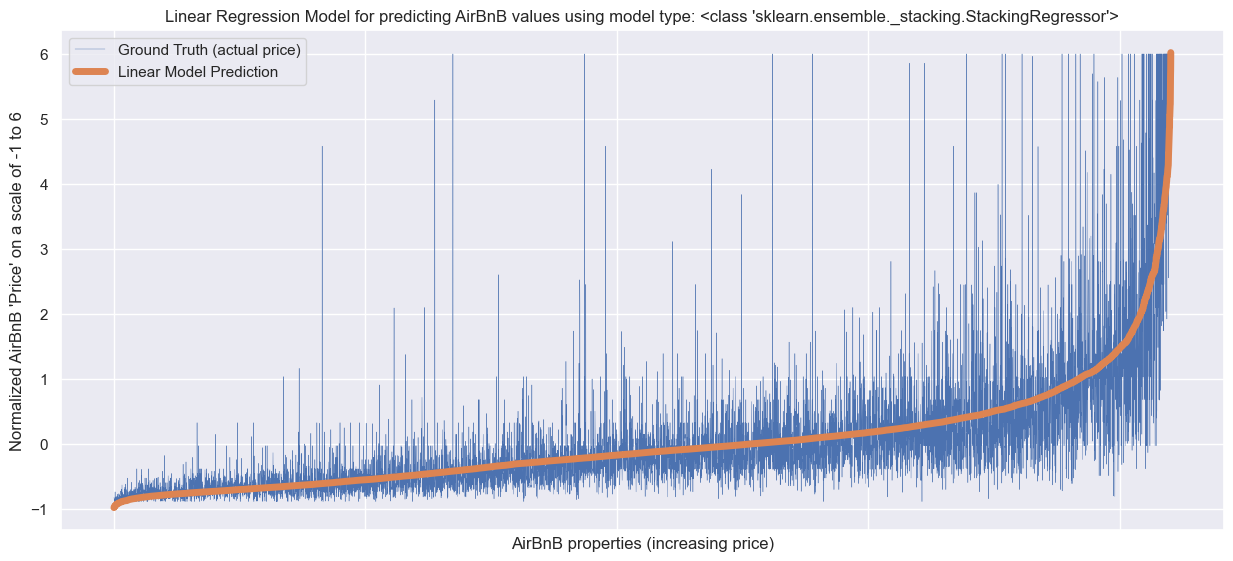


## Tuning the Ensemble Model

Tuning a few of the hyperparameters and finding the best ones

In [ ]:
estimators_best = [("DT", DecisionTreeRegressor(max_depth=8)),
              ("RF", RandomForestRegressor()),
              ("GBDT", GradientBoostingRegressor(n_estimators=100)),
              ("LR", LinearRegression())
             ]

print(estimators_best)

Create a new `StackingRegressor` object with `estimators_best`.

In [ ]:
# training runtime for Best StackingRegressor is 3 minutes 51 sec
# 3 min 44 sec
# 4 min 12 sec with cython

stacking_best_model = StackingRegressor(estimators_best)

# run it once and only once
%timeit -n1 -r1 stacking_best_model.fit(X_train, y_train)

In [ ]:
# Make predictions on the test data
stacking_best_pred = stacking_best_model.predict(X_test)

# Compute the RMSE using mean_squared_error()
rmse = np.sqrt(mean_squared_error(y_test, stacking_best_pred))

# Compute the R2 score using r2_score()
r2 = r2_score(y_test, stacking_best_pred)

print('Root Mean Squared Error: {0}'.format(rmse))
print('R2: {0}'.format(r2))

# Root Mean Squared Error: 0.6190931653162074
# R2: 0.6369709617996435

## Fit and Evaluate Individual Regression Models

### Fit and Evaluate a Linear Regression

In [ ]:
# training runtime for LinearRegression is 146 ms
# second run 98.7 ms

# Create the LinearRegression model object below and assign to variable 'lr_model'
lr_model = LinearRegression()

# Fit the model to the training data below
%timeit -n1 -r1 lr_model.fit(X_train, y_train)

# Call predict() to use the fitted model to make predictions on the test data. Save the results to variable
# 'y_lr_pred'
y_lr_pred = lr_model.predict(X_test)

# Compute the RMSE and R2 (on y_test and y_lr_pred) and save the results to lr_rmse and lr_r2
lr_rmse = np.sqrt(mean_squared_error(y_test, y_lr_pred))
lr_r2 = r2_score(y_test, y_lr_pred)

print('[LR] Root Mean Squared Error: {0}'.format(lr_rmse))
print('[LR] R2: {0}'.format(lr_r2))

# [LR] Root Mean Squared Error: 0.7449320705359715
# [LR] R2: 0.4743911252247154

### Fit and Evaluate a Decision Tree 

Used a grid search to find the best model hyperparameters for the decision tree. 
The best values are: `max_depth=8`, and `min_samples_leaf = 50`. 
Train a decision tree with these hyperparameter values.

In [ ]:
# training runtime for DecisionTreeRegressor is 271 ms, 258ms

# Create the DecisionTreeRegressor model object using the hyperparameter values above and assign to 
# variable 'dt_model'
dt_model = DecisionTreeRegressor(max_depth=8, min_samples_leaf=50)

# Fit the model to the training data below
%timeit -n1 -r1 dt_model.fit(X_train, y_train)

#  Call predict() to use the fitted model to make predictions on the test data. Save the results to variable
# 'y_dt_pred'
y_dt_pred = dt_model.predict(X_test)

# 4: Compute the RMSE and R2 (on y_test and y_dt_pred) and save the results to dt_rmse and dt_r2
dt_rmse = np.sqrt(mean_squared_error(y_test, y_dt_pred))
dt_r2 = r2_score(y_test, y_dt_pred)

print('[DT] Root Mean Squared Error: {0}'.format(dt_rmse))
print('[DT] R2: {0}'.format(dt_r2))

# [DT] Root Mean Squared Error: 0.7350309352041903
# [DT] R2: 0.48827034977613326

### Fit and Evaluate a Gradient Boosted Decision Tree 

Used a Grid Search to optimize hyperparameers for a gradient boosted decision tree.

The best values were: `max_depth=2`, and `n_estimators = 300`

In [ ]:
# training runtime for GradientBoostingRegressor is 16.3 sec
# second run: 16.4 sec

# Create the  GradientBoostingRegressor model object below and assign to variable 'gbdt_model'
gbdt_model = GradientBoostingRegressor(max_depth=2, n_estimators=300)

# Fit the model to the training data
%timeit -n1 -r1 gbdt_model.fit(X_train, y_train)

# Make predictions on the test data
y_gbdt_pred = gbdt_model.predict(X_test)

# Compute the RMSE and R2
gbdt_rmse = np.sqrt(mean_squared_error(y_test, y_gbdt_pred))
gbdt_r2   = r2_score(y_test, y_gbdt_pred)

print('[GBDT] Root Mean Squared Error: {0}'.format(gbdt_rmse))
print('[GBDT] R2: {0}'.format(gbdt_r2))                 

# [GBDT] Root Mean Squared Error: 0.6606472804039243
# [GBDT] R2: 0.5866017354656704

### Fit and Evaluate  a Random Forest

In [ ]:
# training runtime for RandomForestRegressor is 1 min 54 sec
# second run: 1 min 50 sec

# Create a RandomForestRegressor model
rf_model = RandomForestRegressor(max_depth=32, n_estimators=300)

# Fit the model to the training data
%timeit -n1 -r1 rf_model.fit(X_train, y_train)

# make predictions on the test data
y_rf_pred = rf_model.predict(X_test)

# Compute RMSE and R2
rf_rmse = np.sqrt(mean_squared_error(y_test, y_rf_pred))
rf_r2   = r2_score(y_test, y_rf_pred)

print('[RF] Root Mean Squared Error: {0}'.format(rf_rmse))
print('[RF] R2: {0}'.format(rf_r2))

# [RF] Root Mean Squared Error: 0.6285231470020494
# [RF] R2: 0.6258274714894367

## Visualize Model Performance

Plot the RMSE and R2 score for the stacked ensemble model and each regressor.

In [ ]:
RMSE_Results = [rmse, lr_rmse, dt_rmse, gbdt_rmse, rf_rmse]
R2_Results   = [r2, lr_r2, dt_r2, gbdt_r2, rf_r2]

rg = np.arange(5)
width = 0.35

# Create bar plot with RMSE results
fig = plt.figure(figsize=(15,12))
alg_names = ['Stacking Best Model', 'Logistric Regression', 'Decision Tree', 'GBDT', 'Random Forest']
plt.bar(rg - 0.2, RMSE_Results, 0.4, label = 'RSME') 

# Create bar plot with R2 results
plt.bar(rg + 0.2, R2_Results,   0.4, label = 'R2') 

# label the bars indicating which model the pair of RMSE and R2 bars correspond to
plt.xticks(rg, alg_names, rotation=45)

# Label the x (Models) and y axis (RSME and R2) of the plot
plt.xlabel("Models")
plt.ylabel("RSME and R2")
plt.ylim([0,1])
# plt.ylim([0.46, 0.75])        # zoom in
plt.title("Model Performance")
plt.legend(loc='upper left', ncol=2)
plt.show()

In [ ]:
runtimes_in_sec = [231.0, 0.146, 0.271, 16.35, 112.0]

fig = plt.figure(figsize=(15,5))
ax = sns.barplot(x=alg_names, y=runtimes_in_sec)
plt.title('Training Runtimes of algorithms (lower is better)')

g = ax.set_xlabel('Algorithm')
g = ax.set_ylabel('Log10 of Training Runtime in seconds')

ax.set_yscale("log")

# Analysis

The Stacking model was the highest performing model since it has the highest R2 and lowest RSME. It is significantly outperforming the individual models. 
As for the other ensemble methods, the Random Forest was in a close second place but only required half the time to train the model. The GBDT also outperformed the individual models, but only took 1/10th the training time.


## Future work:

### Hyperparameter tuning & Model Selection:
* Randomize the feature subset selection
* Try dropping some of the lower performing models like LinearRegression
* Vary and optimize individual model's hyperparameters that haven't been optimized yet, such as 
    DecisionTreeRegressor: max_features, min_samples_leaf, min_samples_split
    RandomForestRegressor: criterion, max_depth, max_leaf_nodes, min_samples_leaf, min_samples_split
    GradientBoostingRegressor: criterion, learning_rate, loss, max_depth, max_features
    LinearRegression: none really
* Investigate additional cross validation values- try 2 and 4 since it seemed to peak at 3 when given 1,3,5
* Try different methods of combining the stacked models, aka final_estimator

### Feature engineering:

* Resample the most expensive AirBnB listings to give them more representation to improve model performance at the higher end of the price range, or I would futher winsorize the price. - see figure below.
* Investigate dropping features that have low correlation with the label (price).
* Investigate dropping features that have high correlation with other features - see figure below.
* Investigate winsorizing additional features to reduce outliers - see figure showing highest z-scores below



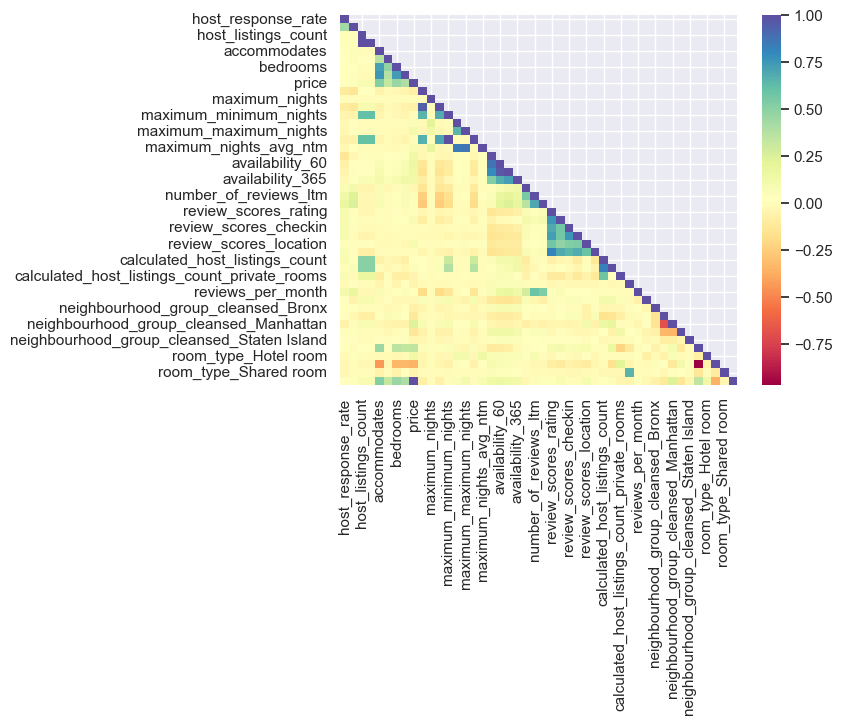

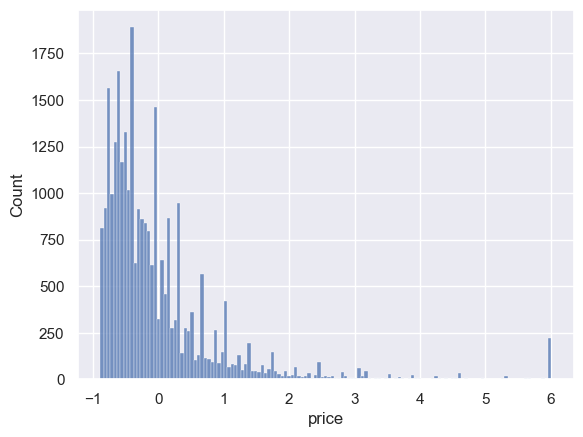

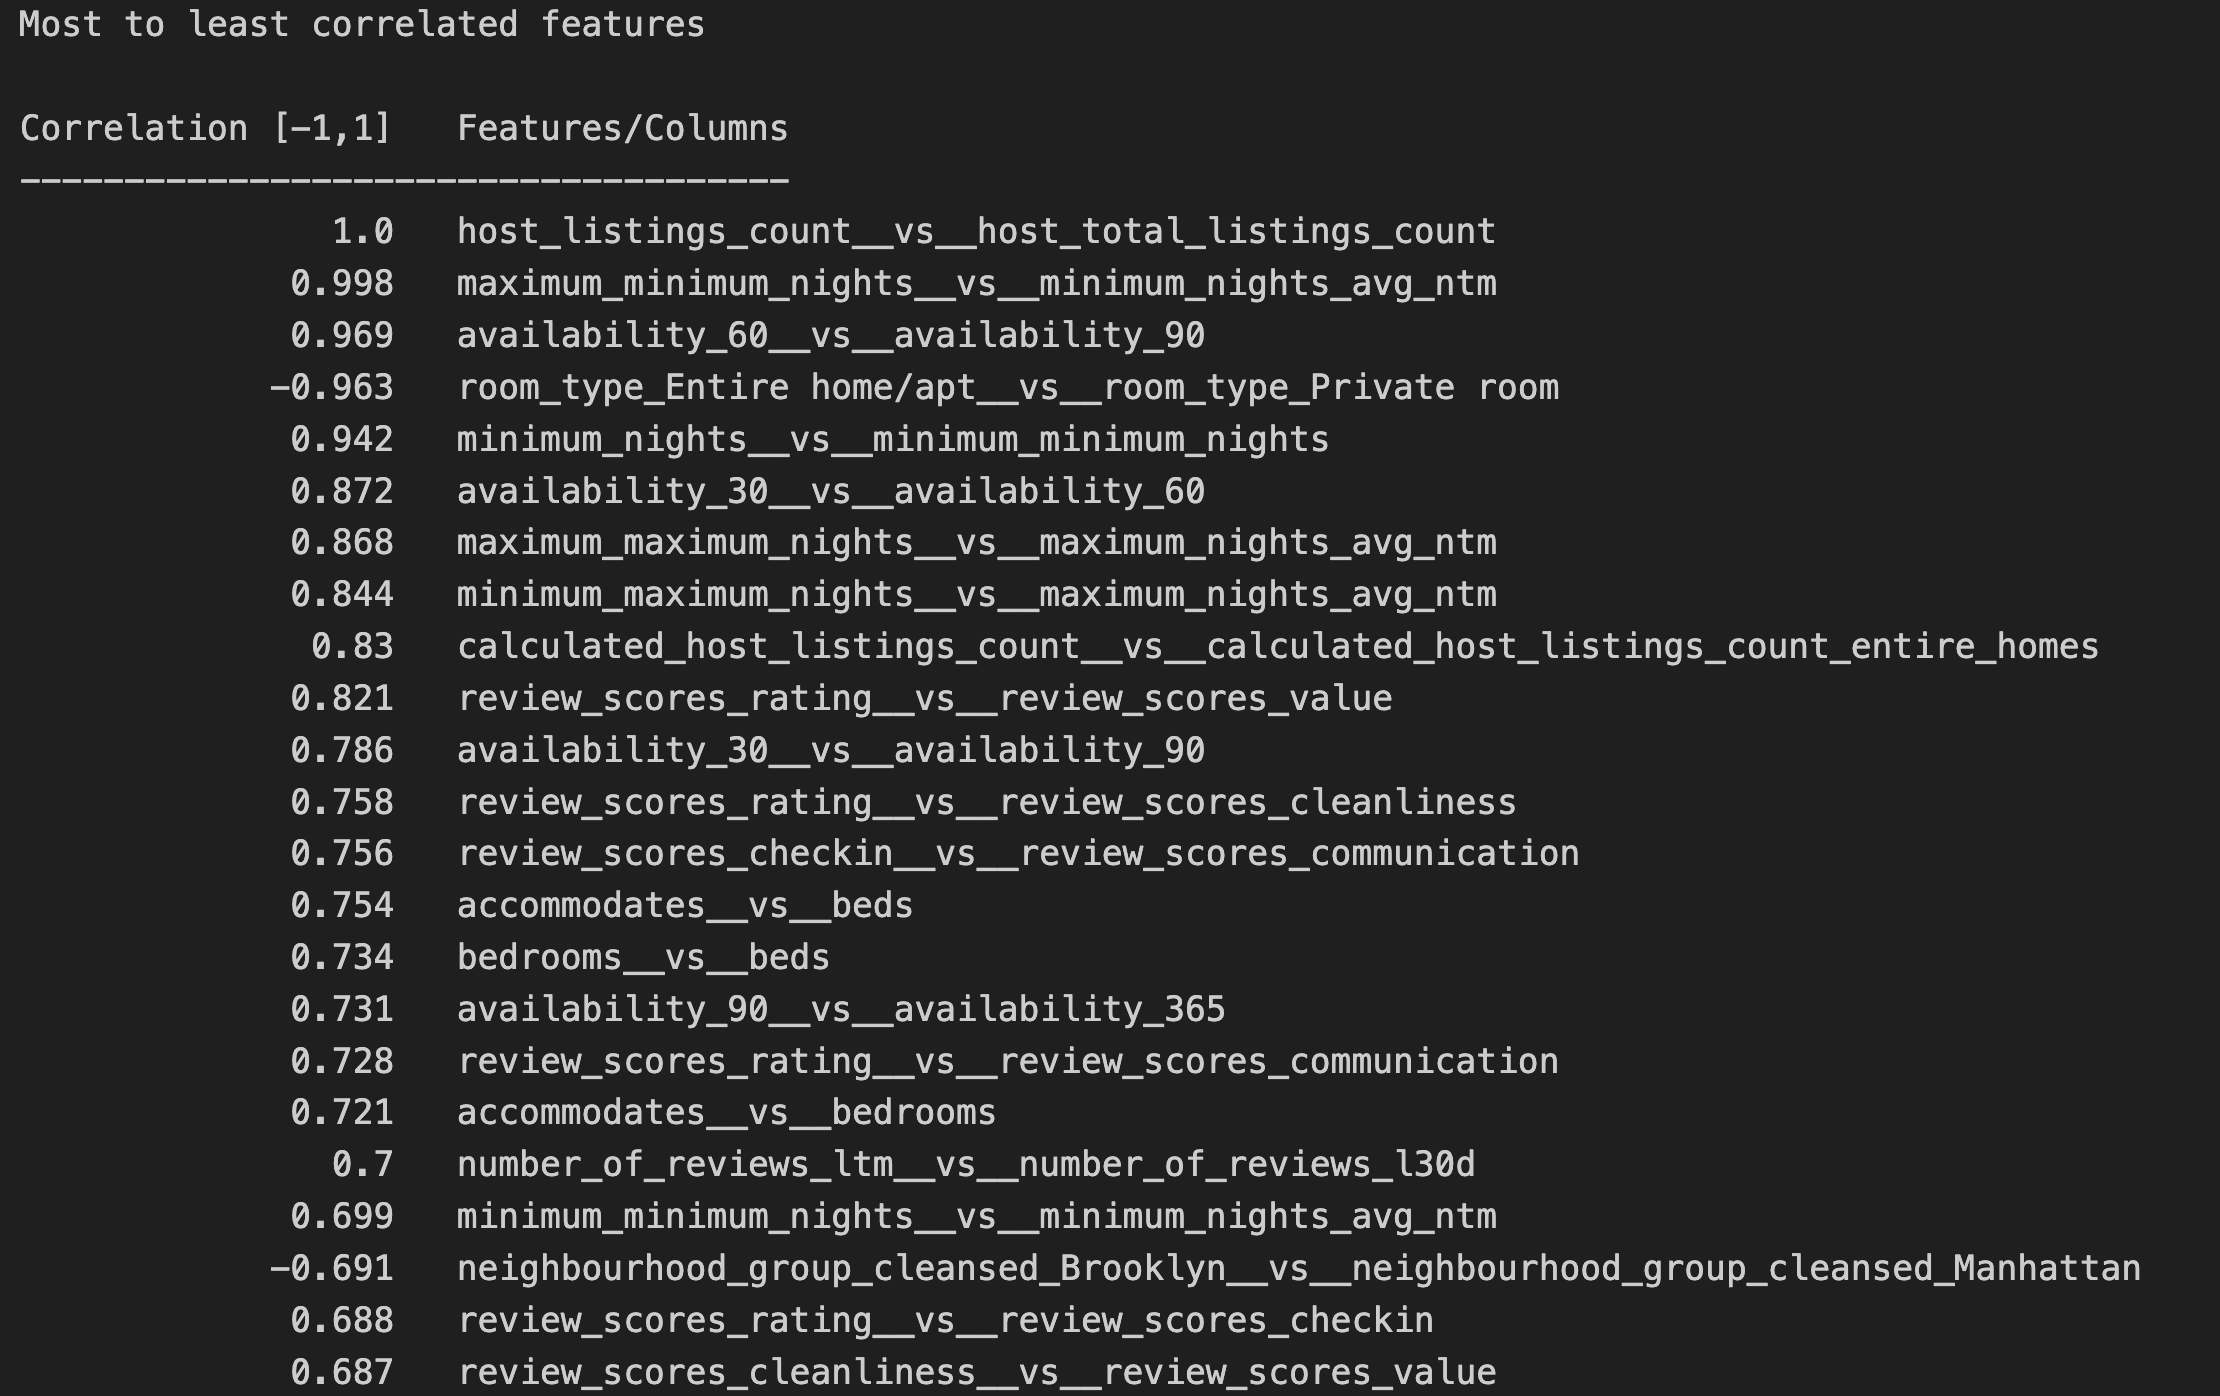

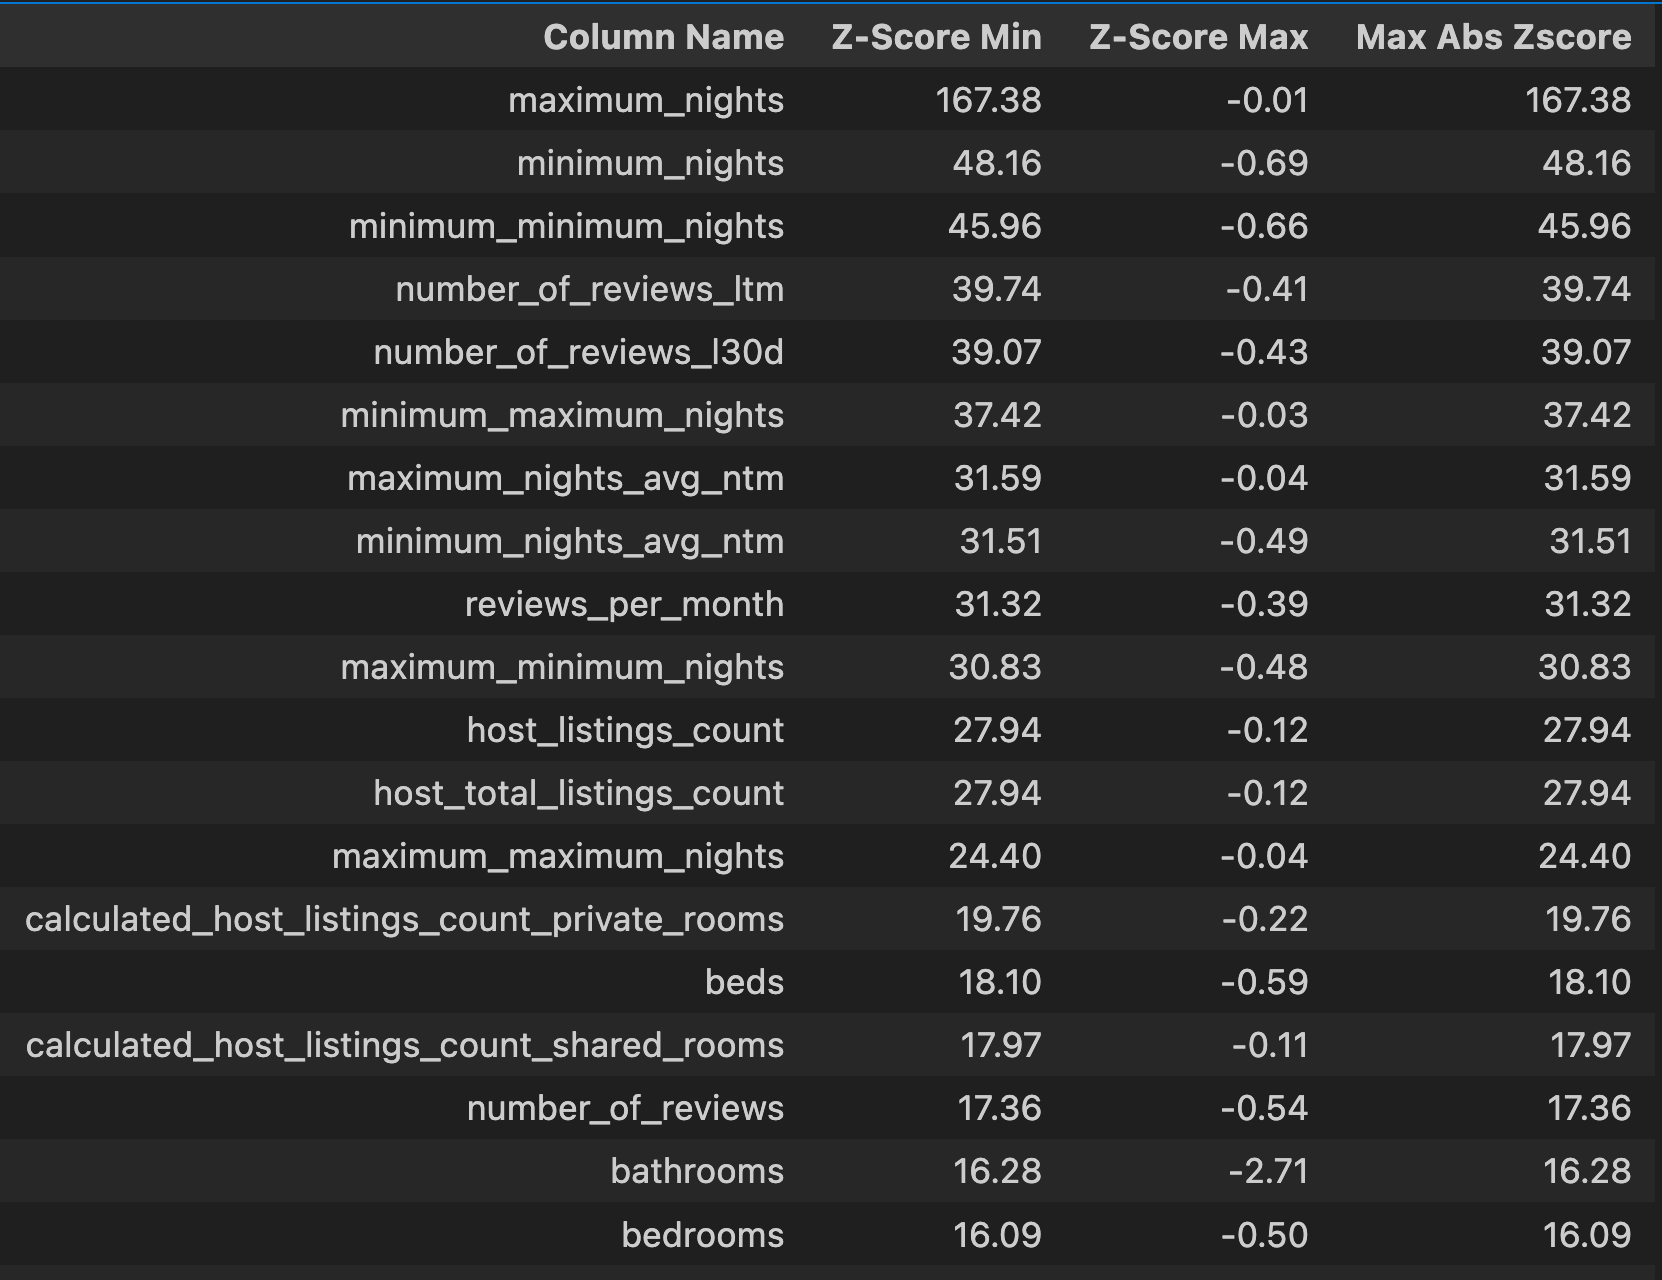